# 16 XGBoost

In [21]:
import gc
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, r2_score
from xgboost import XGBClassifier, XGBRegressor
from collections import Counter

In [22]:
data_url = r'https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv'

In [23]:
data_df = pd.read_csv(data_url)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   censor   532 non-null    int64  
 1   event    532 non-null    int64  
 2   age      532 non-null    int64  
 3   wtkg     532 non-null    float64
 4   hemo     532 non-null    int64  
 5   homo     532 non-null    int64  
 6   drugs    532 non-null    int64  
 7   karnof   532 non-null    int64  
 8   oprior   532 non-null    int64  
 9   z30      532 non-null    int64  
 10  zprior   532 non-null    int64  
 11  preanti  532 non-null    int64  
 12  race     532 non-null    int64  
 13  gender   532 non-null    int64  
 14  str2     532 non-null    int64  
 15  strat    532 non-null    int64  
 16  symptom  532 non-null    int64  
 17  cd40     532 non-null    int64  
 18  cd420    532 non-null    int64  
 19  cd496    532 non-null    int64  
 20  r        532 non-null    int64  
 21  cd80     532 non

In [24]:
# Feature Name Cleaning
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data_df.columns.values]

In [25]:
# Data Quality Checking
col = []
missing = []
level = []
for name in data_df.columns:

    # Missing
    missper = data_df[name].isnull().sum() / data_df.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data_df[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']),
                     pd.DataFrame(missing, columns=['Missing Percentage']),
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data_df.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data_df.shape))

>>>> Data Shape : (532, 22)


In [26]:
summary

,name,Missing Percentage,Level
0,censor,0.0,2
1,event,0.0,358
2,age,0.0,52
3,wtkg,0.0,312
4,hemo,0.0,2
5,homo,0.0,2
6,drugs,0.0,2
7,karnof,0.0,4
8,oprior,0.0,2
9,z30,0.0,2


In [27]:
# X's & Y Split
y = data_df['censor']
X = data_df.drop(columns=['censor'])

In [28]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2023)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 250, 1: 122})
>>>> # of valid data Y : Counter({0: 101, 1: 59})


[XGBoost Parameters]
  - Package : https://xgboost.readthedocs.io/en/stable/
  - booster : Iteration 마다의 Model Run Type을 고를수 있음 (2가지)
    - gbtree : tree-based models
    - gblinear : linear models
  - silent : 학습하면서 running message를 프린트해줌 (Parameter 실험 시 안좋음)
    - 0은 프린트 안해주고, 1은 프린트해줌
  - nthread : 병렬처리 할때 core를 몇개 잡을 것인지
    - default로 잡을 수 있는 모든 core를 잡을 수 있도록 해줌
  - learning_rate : GBM에서 shrinking 하는 것과 같은 것
  - reg_lambda : L2 regularization term on weights (analogous to Ridge regression)
  - reg_alpha : L1 regularization term on weight (analogous to Lasso regression)
  - objective [default=reg:linear]
     - This defines the loss function to be minimized. Mostly used values are:
         - binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
         - multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
         - multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
  - eval_metric [ default according to objective ]
    - The metric to be used for validation data.
    - The default values are rmse for regression and error for classification.
    - Typical values are:
        -    rmse – root mean square error
        -    mae – mean absolute error
        -    logloss – negative log-likelihood
        -    error – Binary classification error rate (0.5 threshold)
        -    merror – Multiclass classification error rate
        -    mlogloss – Multiclass logloss
        -    auc: Area under the curve

[XGBoost]

  - Hyperparameter tuning
  - n_estimators, learning_rate, max_depth, reg_alpha
  - XGBoost은 Hyperparam이 굉장히 많은 알고리즘 중에 하나임
  - 위에 4가지만 잘 조정해도 좋은 결과를 얻을 수 있음

In [29]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

In [30]:
# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
f1_score_ = []

In [33]:
cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:

                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = XGBClassifier(n_estimators=n, learning_rate=l,
                                      max_depth=m, reg_alpha=L1, objective='binary:logistic', random_state=119)
                model.fit(X.iloc[train_idx], y.iloc[train_idx])


                # Train Acc
                y_pred_train = model.predict(X.iloc[train_idx])
                cm_train = confusion_matrix(y.iloc[train_idx], y_pred_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
                print("Train F1-Score : {}".format(f1_score(y.iloc[train_idx], y_pred_train)))

                # Test Acc
                y_pred_test = model.predict(X.iloc[valid_idx])
                cm_test = confusion_matrix(y.iloc[valid_idx], y_pred_test)
                print("Test Confusion Matrix")
                print(cm_test)
                print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
                print("Test F1-Score : {}".format(f1_score(y.iloc[valid_idx], y_pred_test)))
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                f1_score_.append(f1_score(y.iloc[valid_idx], y_pred_test))

                # Model 저장
                import joblib
                joblib.dump(model, './model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(f1_score_[-1], 4)))
                gc.collect()

>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
Train Confusion Matrix
[[228  22]
 [ 19 103]]
Train Acc : 0.8897849462365591
Train F1-Score : 0.8340080971659919
Test Confusion Matrix
[[88 13]
 [13 46]]
TesT Acc : 0.8375
Test F1-Score : 0.7796610169491526
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.3
Train Confusion Matrix
[[230  20]
 [ 19 103]]
Train Acc : 0.8951612903225806
Train F1-Score : 0.8408163265306122
Test Confusion Matrix
[[88 13]
 [12 47]]
TesT Acc : 0.84375
Test F1-Score : 0.7899159663865546
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.5
Train Confusion Matrix
[[230  20]
 [ 19 103]]
Train Acc :

In [38]:
best_model = XGBClassifier(n_estimators=save_n[np.argmax(f1_score_)], learning_rate=save_l[np.argmax(f1_score_)],
                           max_depth=save_m[np.argmax(f1_score_)], reg_alpha=save_L1[np.argmax(f1_score_)], objective='binary:logistic',
                           random_state=119)
best_model.fit(X.iloc[train_idx], y.iloc[train_idx])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=119, ...)

In [39]:
print(f">>> {np.argmax(f1_score_)} <<<\nBest Test f1-score : {f1_score_[np.argmax(f1_score_)]}\nBest n_estimators : {save_n[np.argmax(f1_score_)]}\nBest Learning Rate : {save_l[np.argmax(f1_score_)]}\nBest Max_depth : {save_m[np.argmax(f1_score_)]}\nBest L1-norm : { save_L1[np.argmax(f1_score_)]}")

>>> 9 <<<
Best Test f1-score : 0.85
Best n_estimators : 5
Best Learning Rate : 0.3
Best Max_depth : 3
Best L1-norm : 0.3


In [40]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.448921    event
1   0.170655    cd496
2   0.125130     race
3   0.065897      age
4   0.058242    cd420
5   0.050638  preanti
6   0.045772     cd80
7   0.025039     wtkg
8   0.009705   karnof
9   0.000000      z30
10  0.000000  symptom
11  0.000000    strat
12  0.000000     str2
13  0.000000        r
14  0.000000   oprior
15  0.000000     homo
16  0.000000     hemo
17  0.000000   gender
18  0.000000    drugs
19  0.000000    cd820
20  0.000000     cd40


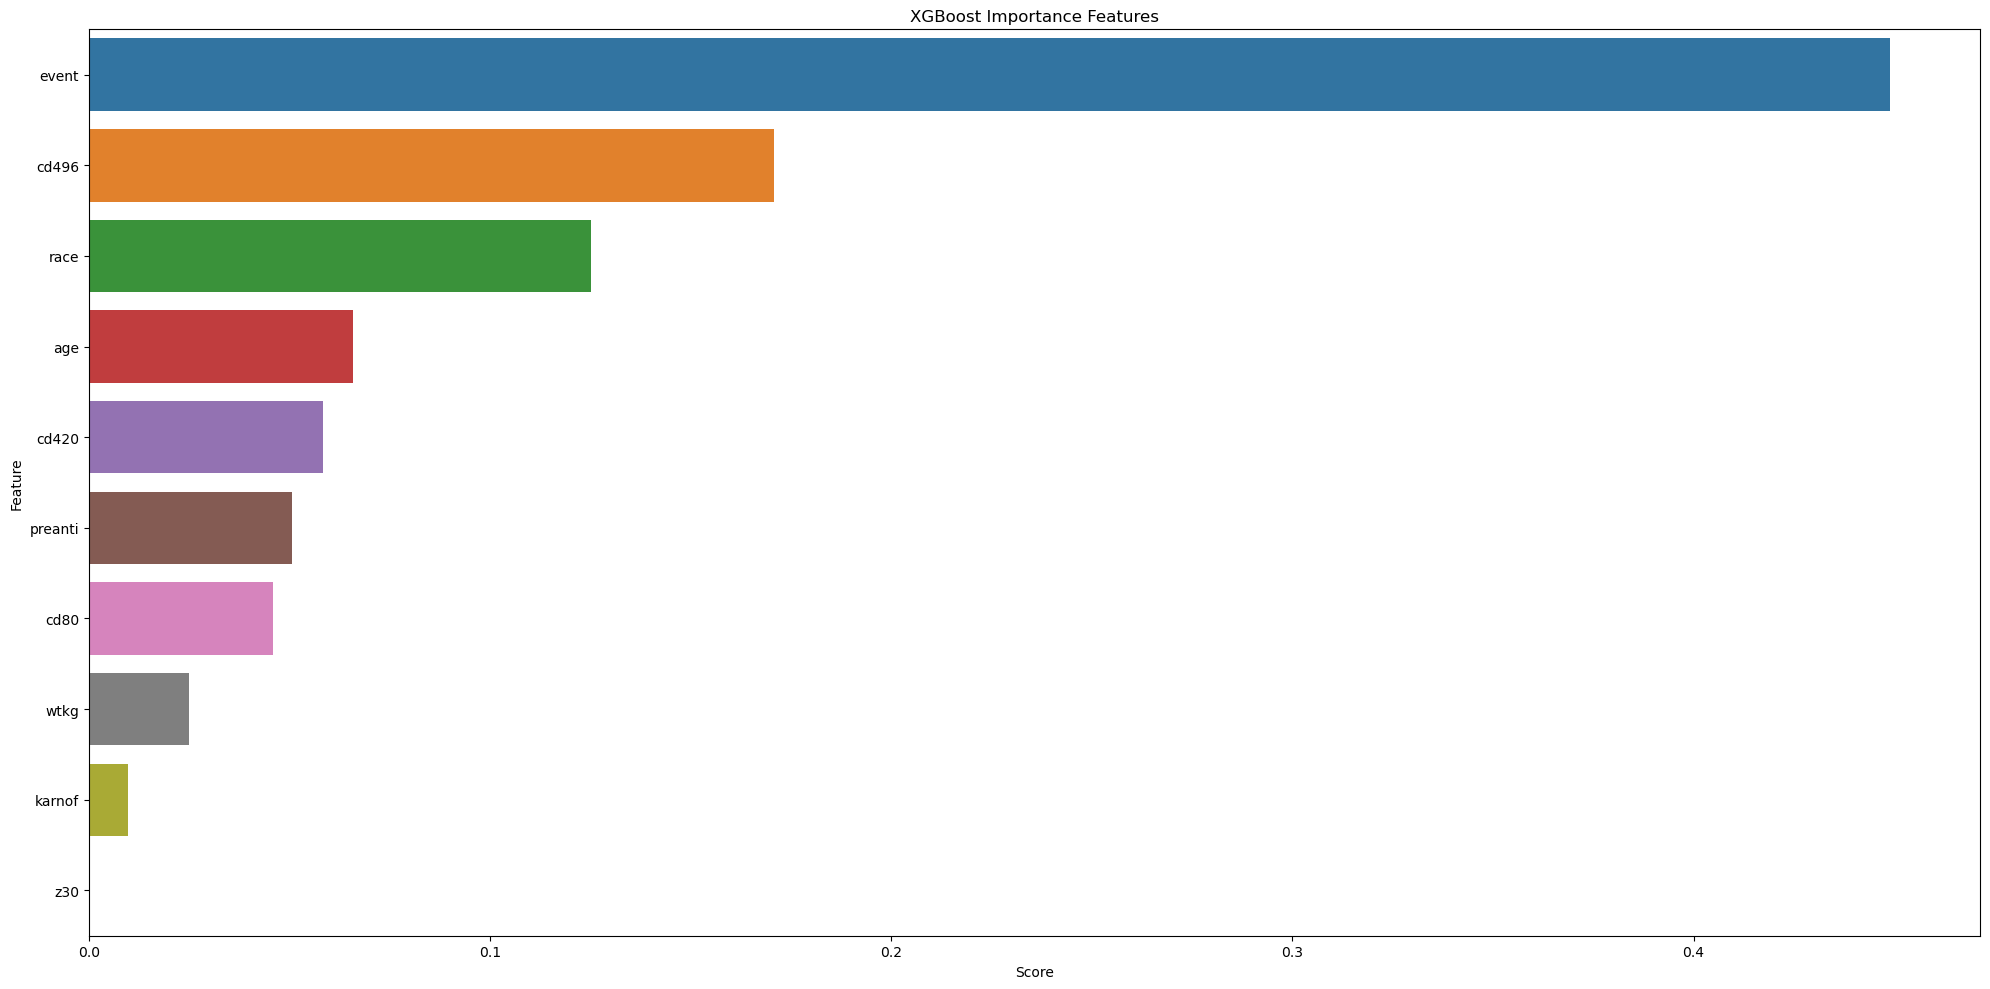

In [41]:
# Importance Score Top 10
feature_map_10 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_10.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('XGBoost Importance Features')
plt.tight_layout()
plt.show()